In [2]:
import numpy as np

import cv2 as cv
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, MiniBatchKMeans

import rospy
import rospkg

from cv_bridge import CvBridge

from cluttered_grasp.srv import superpixel
# Authored by Gary Lvov and Nathaniel Hanson

ModuleNotFoundError: No module named 'cluttered_grasp'

In [4]:
!source ~/cluttered_ws/devel/setup.bash

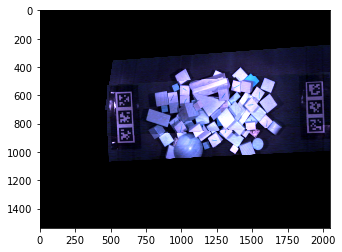

In [64]:
NUM_GROUPS = 4
clusters = MiniBatchKMeans(NUM_GROUPS)

br = CvBridge()

pkg_path = rospkg.RosPack().get_path("cluttered_grasp") # package path
data = np.load(pkg_path + "/associated_normalized_cube.npy")
np.nan_to_num(data, copy=False, nan=0.0)

visu = np.dstack((data[:,:,140],
                  data[:,:,63],
                  data[:,:,36]))
plt.imshow(visu)

In [65]:
data_2d= data.reshape(data.shape[0]*data.shape[1], data.shape[2])
clusters = MiniBatchKMeans(NUM_GROUPS)

kmeans = clusters.partial_fit(data_2d)
data_kmeans = kmeans.predict(data_2d)
data_kmeans = data_kmeans.reshape(data.shape[:2])

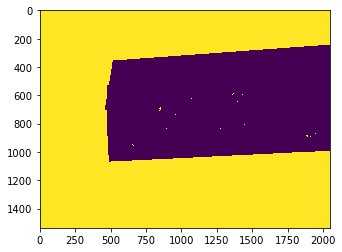

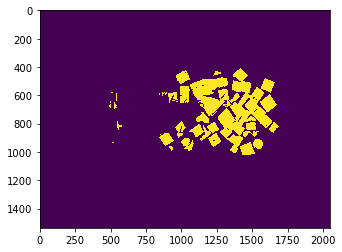

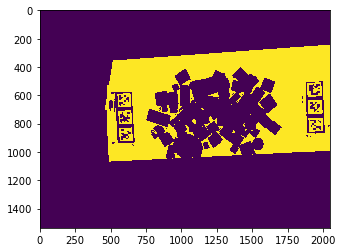

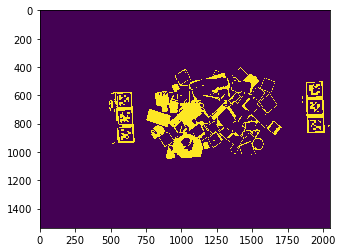

In [66]:
num_pix_per_group = []
for group in range(NUM_GROUPS):
    plt.figure()
    plt.imshow(data_kmeans == group)
    num_pix_per_group.append(np.sum((data_kmeans == group)))

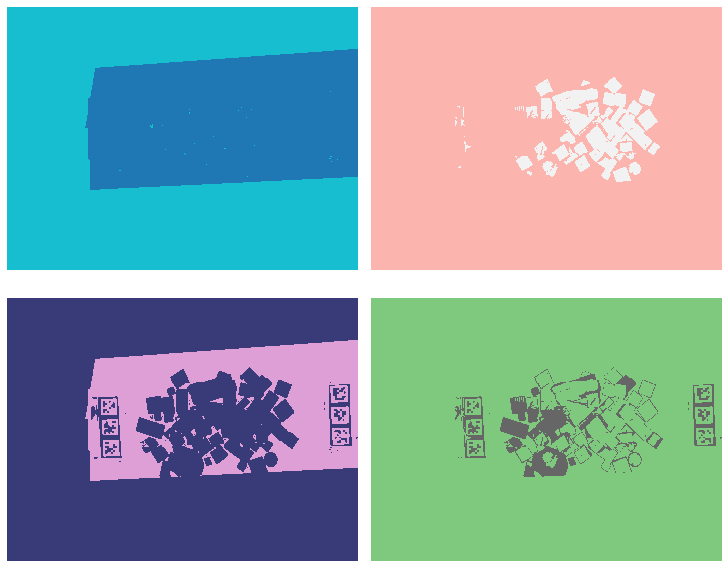

In [67]:

fig = plt.figure(figsize=(10,8), constrained_layout=True)

axarr = fig.subplots(2, 2)

curr = 0
cmaps = ['tab10', 'Pastel1', 'tab20b', 'Accent']
for axx in range(2):
    for axy in range(2):
        img = data_kmeans == curr
        axarr[axx][axy].imshow(img,  cmap=cmaps[curr])
        axarr[axx][axy].axis('off')
        curr += 1 

fig.savefig("kmeans.png", bbox_inches='tight')

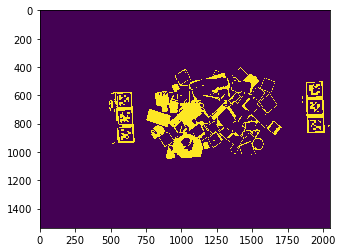

In [68]:
anom_group_num = num_pix_per_group.index(min(num_pix_per_group))
plt.imshow(data_kmeans == anom_group_num)

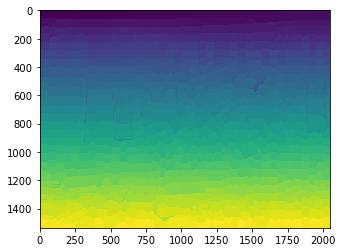

In [70]:
def get_superpixels():
    rospy.wait_for_service("/superpixel")
    try:
        get_superpixels = rospy.ServiceProxy("/superpixel", superpixel)
        superpixels = get_superpixels().image # get the image in bytes format
        superpixels = br.imgmsg_to_cv2(superpixels)        
        return superpixels
    
    except rospy.ServiceException as e:
        print("Service call failed: %s"%e)

superpixels = get_superpixels()
plt.imshow(superpixels)


In [ ]:
print(superpixels.shape)

In [ ]:
grouped_kmeans = []
for superpixel in np.unique(superpixels):
    clusters = []
    for group in range(NUM_GROUPS):
        clusters.append(np.sum((data_kmeans == group)[superpixels == superpixel]))
    total_pix = sum(clusters)
    if clusters[anom_group_num]/total_pix > 0.25:
        mode = anom_group_num
    else:
        mode = clusters.index(max(clusters))
        
    grouped_kmeans.append(mode)

In [ ]:
cow = np.zeros_like(superpixels)

for pix, mode in enumerate(grouped_kmeans):
    if (grouped_kmeans[pix] == anom_group_num):
        cow[superpixels == pix] = 1
    else:
        cow[superpixels == pix] = 0
    #cow[superpixels == pix] = grouped_kmeans[pix]
    
plt.imshow(cow, cmap='bwr')
#plt.imsave('cybercow.png', cow, cmap='bwr')

In [ ]:
anom_group_num

In [ ]:
plt.imsave("cow.png", cow, cmap='Pastel1')

In [ ]:
fig = plt.figure()
axarr = fig.subplots(1, 1)

fig.imshow(cow, cmap='cool')
axarr.axis('off')
fig.savefig('cybercow.png')